В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [78]:
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv')

In [79]:
train_df, val_df = split_train_val(raw_df, target_col=raw_df.columns[-1])

In [80]:
train_inputs, train_targets = separate_inputs_targets(train_df, input_cols=list(raw_df.columns[:-1]), target_col=raw_df.columns[-1])
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols=list(raw_df.columns[:-1]), target_col=raw_df.columns[-1])

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [81]:
cat_features = train_inputs.select_dtypes(include='object').columns
train_inputs[cat_features] = train_inputs[cat_features].astype('category')
val_inputs[cat_features] = val_inputs[cat_features].astype('category')

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [82]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [83]:
xgb_clf = XGBClassifier(
    max_depth=4,
    n_estimators=20,
    enable_categorical=True, 
    missing=np.nan,
    device='cuda'
)

xgb_clf.fit(train_inputs, train_targets)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [84]:
train_pred = xgb_clf.predict(train_inputs)
val_pred = xgb_clf.predict(val_inputs)

In [85]:
def get_auroc(targets, probs, name = ''):
    fpr, tpr, thresholds = roc_curve(targets, probs)

    # Обчислення AUC
    roc_auc = auc(fpr, tpr)

    # Виведення AUC
    print(f'Area Under ROC Curve (AUC) for {name}: {roc_auc:.4f}')

In [86]:
get_auroc(train_targets, train_pred, 'Train')
get_auroc(val_targets, val_pred, 'Validation')

Area Under ROC Curve (AUC) for Train: 0.8541
Area Under ROC Curve (AUC) for Validation: 0.8200


**Спостереження:** Модель працює досить добре. `AUROC=0.85` на тренувальних даних і `AUROC=0.82` на валідаційних даних, що вказує на те, що модель трохи краще зафітилась на тренувальному наборі. 

Якщо порівнювати з DecisionTrees, яку я отримала раніше, то ця модель показує гірші результати. Оскільки попередня модель давала результат на тренувальних та на валідаційних даних `AUROC=0.92`. 

**Висновок:** Якість покращити не вийшло.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [87]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [88]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        verbose=False)
    pred = clf.predict(val_inputs)
    fpr, tpr, thresholds = roc_curve(val_targets, pred)
    roc_auc = auc(fpr, tpr)

    return {'loss': -roc_auc, 'status': STATUS_OK}

In [89]:
# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 20, 400, 20),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.4),
    'max_depth': hp.quniform('max_depth', 5, 25, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.2, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.7),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    missing=np.nan,
    device='cuda',
)

100%|███████████████████████████████████████████████| 20/20 [00:07<00:00,  2.84trial/s, best loss: -0.8267953906303587]
Найкращі гіперпараметри:  {'colsample_bytree': 0.9987658454239337, 'gamma': 0.6459941032872756, 'learning_rate': 0.2718491737290319, 'max_depth': 21, 'min_child_weight': 10, 'n_estimators': 40, 'reg_alpha': 0.27864896459548727, 'reg_lambda': 0.7502727729292715, 'subsample': 0.6006304959914442}


In [90]:
final_clf.fit(train_inputs, train_targets)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9987658454239337, device='cuda',
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=0.6459941032872756,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2718491737290319,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=21, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [91]:
final_train_pred = final_clf.predict(train_inputs)
final_val_pred = final_clf.predict(val_inputs)

In [92]:
final_train_auroc = get_auroc(train_targets, final_train_pred, 'Train')
final_val_auroc = get_auroc(val_targets, final_val_pred, 'Validation')

Area Under ROC Curve (AUC) for Train: 0.8771
Area Under ROC Curve (AUC) for Validation: 0.8101


**Спостереження:** Точність моделі погіршилась, зараз `AUROC=0.81` на валідаційних даних. Також видно, що модель перенавчилась, оскільки на тренувальних даних `AUROC=0.88`.

**Висновок:** Якість покращити не вийшло.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [105]:
import lightgbm as lgb

In [106]:
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in cat_features]

In [107]:
# Створення датасетів
train_data = lgb.Dataset(train_inputs, label=train_targets, categorical_feature=cat_feature_indexes)
val_data = lgb.Dataset(val_inputs, label=val_targets, categorical_feature=cat_feature_indexes, reference=train_data)

In [108]:
# Параметри моделі
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 50
}

# Навчання моделі
lgb_clf = lgb.train(params, train_data, valid_sets=[val_data], valid_names=['val'])

C:\Users\Anastasiia\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561


In [109]:
# Передбачення
train_pred = lgb_clf.predict(train_inputs)
val_pred = lgb_clf.predict(val_inputs)

In [122]:
train_auroc = get_auroc(train_targets, train_pred, 'Train')
val_auroc = get_auroc(val_targets, val_pred, 'Validation')

Area Under ROC Curve (AUC) for Train: 0.9501
Area Under ROC Curve (AUC) for Validation: 0.9355


**Спостереження:** Модель працює добре. Вона видає `AUROC=0.95` на тренувальних даних і `AUROC=0.94` на валідаційних даних, що вказує на те, що модель добре генералізує. 

Якщо порівнювати з XGBoostClassifier, яку я отримала раніше, то ця модель показує набагато кращі результати. Оскільки попередня модель давала результат на валідаційних даних `AUROC=0.82`. 

**Висновок:** Вийшло покращити якість моделі.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [135]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_split_gain=params['min_split_gain']
    )
    
    # Use Dataset constructor to include categorical features
    train_data = lgb.Dataset(train_inputs, label=train_targets, categorical_feature=cat_feature_indexes)
    val_data = lgb.Dataset(val_inputs, label=val_targets, categorical_feature=cat_feature_indexes, reference=train_data)

    clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)], eval_metric='auc')
    pred = clf.predict_proba(val_inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(val_targets, pred)
    roc_auc = auc(fpr, tpr)

    return {'loss': -roc_auc, 'status': STATUS_OK}

In [168]:
# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 10),
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.2),
    'max_depth': hp.quniform('max_depth', 5, 25, 1),
    'num_leaves': hp.quniform('num_leaves', 50, 150, 5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.                 
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558                                                   
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.                
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1826                                                                                      
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13                           
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561                                        
[LightGBM] [Info] Start traini

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Warning] No further splits w

In [169]:
print("Найкращі гіперпараметри: ", best)

Найкращі гіперпараметри:  {'colsample_bytree': 0.6954658778758189, 'learning_rate': 0.026548041435343582, 'max_depth': 6, 'min_child_weight': 5, 'min_split_gain': 0.05614078496520474, 'n_estimators': 60, 'num_leaves': 135, 'reg_alpha': 0.45290016421653645, 'reg_lambda': 0.09708570455680965, 'subsample': 0.5731173257931914}


In [170]:
# Навчання фінальної моделі з найкращими гіперпараметрами
final_lgb_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

In [171]:
final_lgb_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)], categorical_feature=cat_feature_indexes)

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set with categorical_column=2,4,5, will be overridden by cat_feature=2,4,5. Current value: categorical_feature=2,4,5
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start tr

LGBMClassifier(cat_feature=[2, 4, 5], colsample_bytree=0.6954658778758189,
               learning_rate=0.026548041435343582, max_depth=6,
               min_child_weight=5, min_split_gain=0.05614078496520474,
               missing=nan, n_estimators=60, num_leaves=135,
               reg_alpha=0.45290016421653645, reg_lambda=0.09708570455680965,
               subsample=0.5731173257931914)

In [172]:
final_train_pred_proba = final_lgb_clf.predict_proba(train_inputs)[:, 1]
final_val_pred_proba = final_lgb_clf.predict_proba(val_inputs)[:, 1]

final_train_roc_auc = roc_auc_score(train_targets, final_train_pred_proba)
final_val_roc_auc = roc_auc_score(val_targets, final_val_pred_proba)

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Unknown parameter: missing


In [173]:
final_train_roc_auc.round(2), final_val_roc_auc.round(2)

(0.96, 0.94)

**Спостереження:** Модель працює добре. Вона видає `AUROC=0.96` на тренувальних даних і `AUROC=0.94` на валідаційних даних, що вказує на те, що модель добре генералізує. 

Якщо порівнювати з моделлю, яку я отримала в попередньому пункті, то ця модель показує трохи кращі результати, але лише на тренувальній вибірці. Оскільки попередня модель давала результат на тренувальних даних `AUROC=0.95`. 

**Висновок:** Вийшло покращити якість моделі.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [176]:
test_data = pd.read_csv('bank-customer-churn-prediction-dlu/test.csv')

In [180]:
cat_features = test_data.select_dtypes(include='object').columns
test_data[cat_features] = test_data[cat_features].astype('category')

In [182]:
y_test_probs = final_lgb_clf.predict_proba(test_data)[:, 1]
test_data['Exited'] = y_test_probs

sample_submission = pd.read_csv('bank-customer-churn-prediction-dlu/sample_submission.csv')
sample_submission['Exited'] = test_data['Exited']

sample_submission.to_csv('bank-customer-churn-prediction-dlu/submission_lgb_clf.csv', index=False)

[LightGBM] [Warning] Unknown parameter: missing


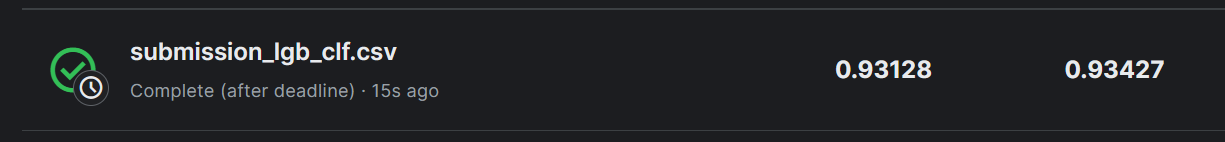